### Task 1: Define the Data Analysis Workflow

##### This task includes data loading, understanding, and preparation steps. It also includes understanding the ARIMA and Bayesian models in preparation for time series analysis.
### Step 1.1: Load and Explore Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# import pymc3 as pm
import pymc as pm

import numpy as np
import pymc as pm


In [2]:
# Load data
data = pd.read_csv('/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/data/Copy of BrentOilPrices.csv', parse_dates=['Date'], dayfirst=True)
data.set_index('Date', inplace=True)



/tmp/ipykernel_53897/51825963.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/data/Copy of BrentOilPrices.csv', parse_dates=['Date'], dayfirst=True)


In [3]:
# Check data info
print(data.info())
print(data.head())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB
None
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


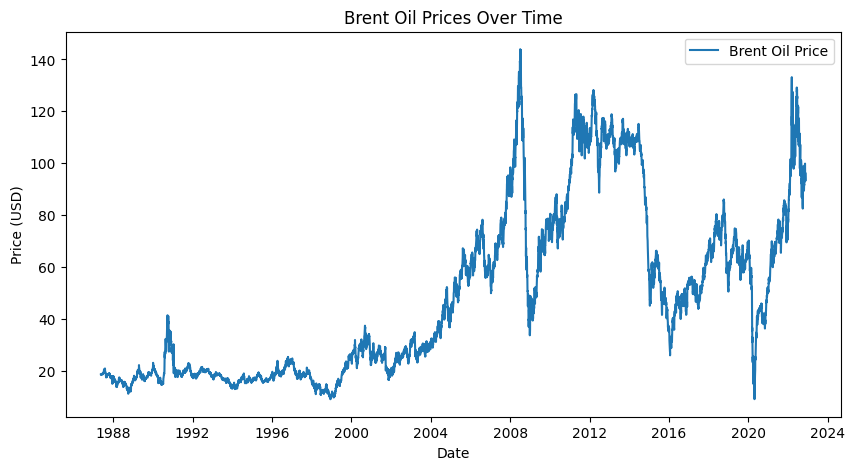

In [4]:
# Visualize initial trends
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

### Step 1.2: Understand the Model and Data

#### We start by understanding the structure and assumptions of ARIMA and Bayesian models.
#### ARIMA Model Explanation

#### The ARIMA (AutoRegressive Integrated Moving Average) model is commonly used for time series analysis. The model parameters are:

 #### p: Number of lag observations.
 #### d: Degree of differencing.
 #### q: Size of the moving average window.

   

### Step 1.3: Define the ARIMA Model

In [5]:
# Differencing to make series stationary
data_diff = data['Price'].diff().dropna()

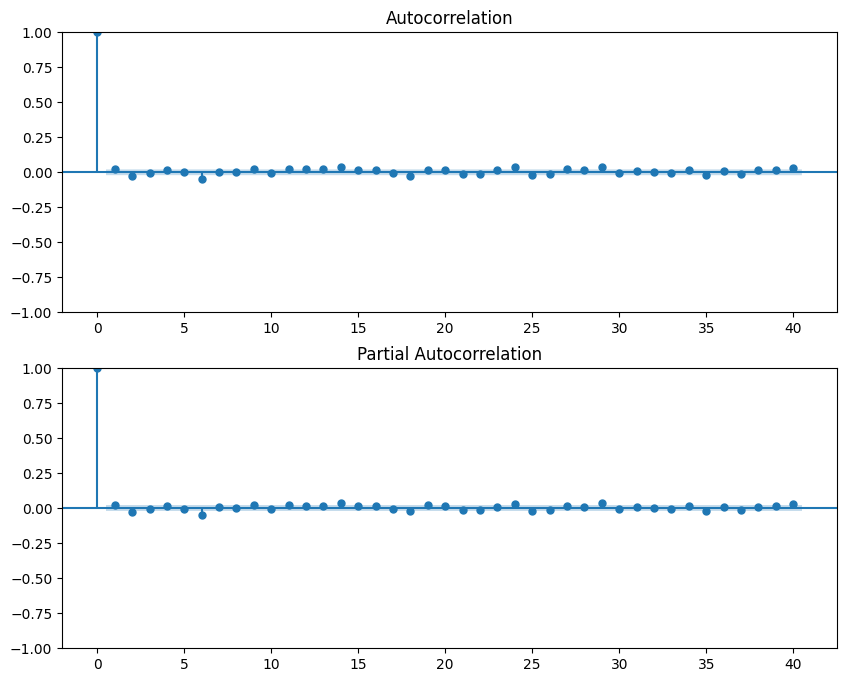

In [6]:
# Plot ACF and PACF to help with ARIMA parameters
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(data_diff, ax=ax[0])
sm.graphics.tsa.plot_pacf(data_diff, ax=ax[1])
plt.show()

In [7]:
# Define and fit ARIMA model
model = ARIMA(data['Price'], order=(1, 1, 1))
arima_result = model.fit()
print(arima_result.summary())

/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Mon, 04 Nov 2024   AIC                          29093.899
Time:                        11:44:58   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


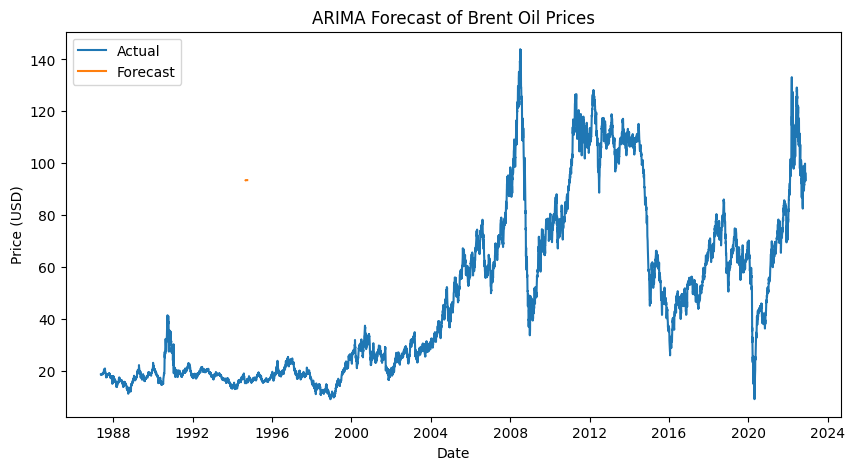

In [8]:
# Plot forecast
arima_forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Price'], label='Actual')
plt.plot(arima_forecast.index, arima_forecast, label='Forecast')
plt.title('ARIMA Forecast of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### Step 1.4: Set Up Bayesian Change Point Detection

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [change_point]
>NUTS: [mu1, mu2]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
/home/ayalk94/Documents/GitHub/Analysis_of_Brent_Oil_Price_Dynamics/env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
We recommend running at least 4 chains for robust computation of convergence diagnostics


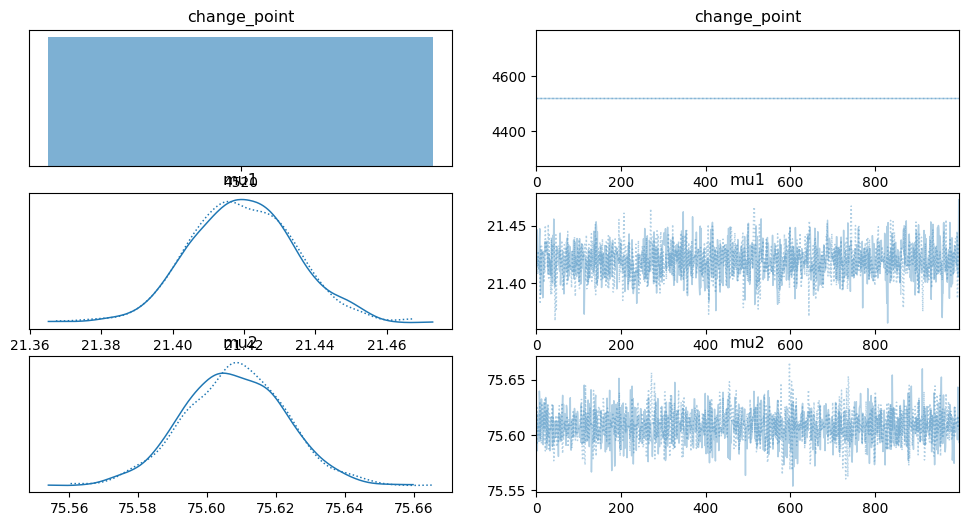

In [9]:
# Change point analysis with Bayesian modeling
with pm.Model() as model:
    # Prior for change point
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(data) - 1)

    # Priors for price levels
    mu1 = pm.Normal('mu1', mu=data['Price'][:50].mean(), sigma=10)
    mu2 = pm.Normal('mu2', mu=data['Price'][50:].mean(), sigma=10)

    # Switch in mean at change point
    price = pm.math.switch(change_point >= np.arange(len(data)), mu1, mu2)
    observed = pm.Normal('observed', mu=price, sigma=1, observed=data['Price'].values)

    # Sample from posterior
    trace = pm.sample(1000, tune=1000, cores=1)

# Plot results
pm.plot_trace(trace)
plt.show()